# SIDES Simulation

This directory contains models made with simulations generated using [SIDES](https://gitlab.lam.fr/mbethermin/sides-public-release/-/tree/main/PYSIDES).  

The catalog and maps generated in the Notebook [S0_Generate_Simulated_Herschel_Maps_and_Catalog](http://localhost:8888/notebooks/Repositories/simstack3/viero2022/notebooks/Appendix/sides_simulation/S0_Generate_Simulated_Herschel_Maps_and_Catalog.ipynb) is used here to compare to the COSMOS2020 sample in Viero2022.

This notebook investigates the *LePhare*-derived redshift probability distribution of each object, as provided by COSMOS2020.  

We plot a subset of the P(z) in each bin to get a sense of the redshift probabilities in each bin.  As expected, higher-redshift, fainter (i.e., lower stellar mass) suffer from greater uncertainty in their estimated photometric redshifts.

In [1]:
# Standard modules
import pdb
import os
import sys
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import gridspec

from lmfit import Parameters, minimize, fit_report

import warnings
warnings.filterwarnings("ignore")

sys.path.append("../../../..")

from simstackwrapper import SimstackWrapper
from simstackresults import SimstackResults
from simstackplots import SimstackPlots
from simstacktoolbox import SimstackToolbox

#from scipy.signal import find_peaks
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Import Catalog and PZ to link objects and their photometric redshift PDFs

### COSMOS2020 Catalog

In [2]:
# Import catalog with SimstackWrapper
combined_pickle_filename = "cosmos2020_farmer_nuvrj_0p01_0p5_1_1p5_2_2p5_3_3p5_4_5_6_8_10p0_X_4_foregnd_atonce_bootstrap_1-150"
combined_pickle_path = os.environ['PICKLESPATH']+'/'+os.path.join("simstack","stacked_flux_densities", "spire" , combined_pickle_filename)
underscore_suffix = ""
path_ini_file = os.path.join(combined_pickle_path, "cosmos2020_farmer.ini")
path_pickle_file = os.path.join(combined_pickle_path, combined_pickle_filename+".pkl")
if os.path.isfile(path_ini_file):
    simstack_catalog_object = SimstackWrapper(path_ini_file, read_maps=False, read_catalog=True, keep_catalog=True, stack_automatically=False, save_automatically=False)
else:
    print(path_ini_file+' not found')

In [3]:
# Load Table into a pandas DataFrame
cosmos2020 = simstack_catalog_object.catalog_dict['tables']['full_table']

### P(z) 

In [4]:
# Import table with astropy
path_cosmos2020_pz = os.path.join(os.environ['CATSPATH'], "cosmos","PZ","COSMOS2020_FARMER_R1_v2.0_LEPHARE_PZ.fits")
if os.path.isfile(path_cosmos2020_pz):
    print('Open ',path_cosmos2020_pz)
    with fits.open(path_cosmos2020_pz) as hdul_pz:
        hdul_pz.verify('fix')
        cosmos_catalog_pz = hdul_pz[0].data
else:
    print(path_cosmos2020_pz, ' not found')

Open  D:\catalogs\cosmos\PZ\COSMOS2020_FARMER_R1_v2.0_LEPHARE_PZ.fits


In [5]:
# Load Table into a pandas DataFrame
cosmos2020_pz = pd.DataFrame(cosmos_catalog_pz)

In [6]:
def visualize_photometric_redshift_pZ(self, catalog):
    bin_keys = list(self.config_dict['parameter_names'].keys())
    wv_keys = list(self.results_dict['band_results_dict'].keys())
    
    zlen = len(self.config_dict['parameter_names'][bin_keys[0]])
    mlen = len(self.config_dict['parameter_names'][bin_keys[1]])
    plen = len(self.config_dict['parameter_names'][bin_keys[2]])
    wlen = len(wv_keys)
    
    width_ratios = [i for i in np.ones(zlen)]
    gs = gridspec.GridSpec(mlen, zlen, width_ratios=width_ratios,
                       wspace=0.0, hspace=0.0, top=0.95, bottom=0.05, left=0.17, right=0.845)
    fig = plt.figure(figsize=(32, 10))
    
    if len(self.config_dict['parameter_names']) == 3:
        for iz, zlab in enumerate(self.config_dict['parameter_names'][bin_keys[0]]):
            for ip, plab in enumerate(self.config_dict['parameter_names'][bin_keys[2]]):
                if ip:
                    for im, mlab in enumerate(self.config_dict['parameter_names'][bin_keys[1]]):
                        id_label = "__".join([zlab, mlab, plab])

                        ax = plt.subplot(gs[3-im, iz])
                        ax.set_title(zlab.replace('redshift_','z=').replace('_','-'))
                        
                        m = [float(i) for i in mlab.split('_')[2:]]
                        z = [float(i) for i in zlab.split('_')[1:]]
                        
                        #pdb.set_trace()
                        ind_bin = (catalog['lp_zBEST'] > z[0]) & \
                        (catalog['lp_zBEST'] < z[1]) & \
                        (catalog['lp_mass_med'] >= m[0]) & \
                        (catalog['lp_mass_med'] < m[1]) & \
                        (catalog['sfg'] == ip)
                        idz=catalog.ID[ind_bin].values
                        nplotted = 0
                        for i in range(len(idz)):
                            #if (not i % 10) and (nplotted < 10):
                            if (nplotted < 15):
                                c = cosmos2020_pz[0] == idz[i]
                                indz = cosmos2020_pz[0][c]
                                pz = cosmos2020_pz.loc[int(indz.values)][1:].astype('float64')/np.sum(cosmos2020_pz.loc[int(indz.values)][1:].astype('float64'))
                                ax.plot(cosmos2020_pz.iloc[0][1:], pz, lw=0.5)
                                nplotted+=1
                                    
                        ax.set_yscale('log')
                        if im:
                            ax.set_xticklabels([])
                        else:
                            ax.set_xlabel('redshift')
                        
                        if iz:
                            ax.set_yticklabels([])
                        else:
                            ax.set_ylabel('P(z)')
                            
                        if iz == zlen - 1:
                            ax.yaxis.set_label_position("right")
                            ax.set_ylabel(mlab.replace('stellar_mass_', 'log(M)=').replace('_', '-'))

                        ax.set_xlim([0.01,9.9])


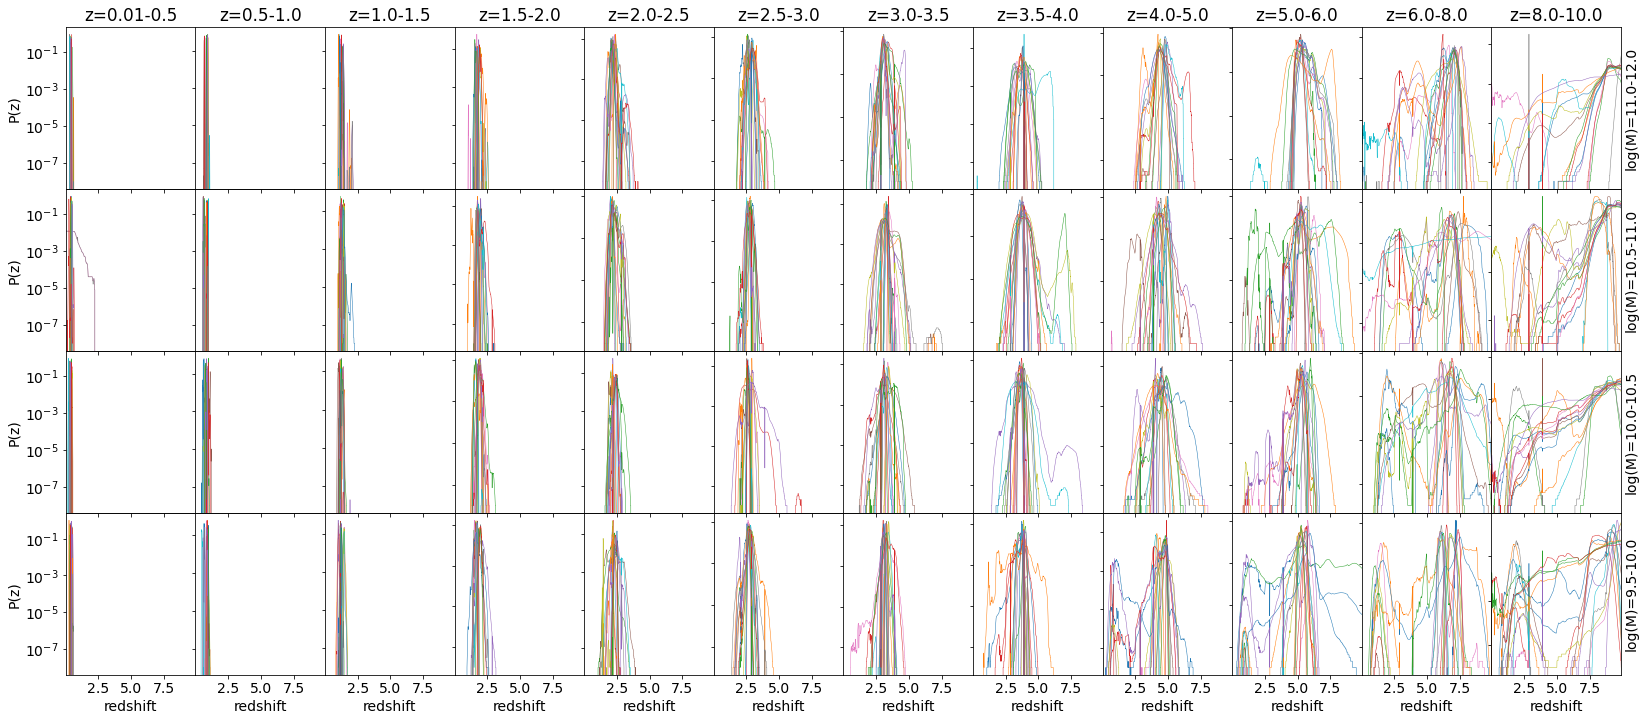

In [7]:
visualize_photometric_redshift_pZ(simstack_catalog_object, cosmos2020)